<a href="https://colab.research.google.com/github/PabloJRW/TinyML-sineFunction/blob/main/TinyML_Sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [274]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [275]:
np.random.seed(12)
tf.random.set_seed(12)

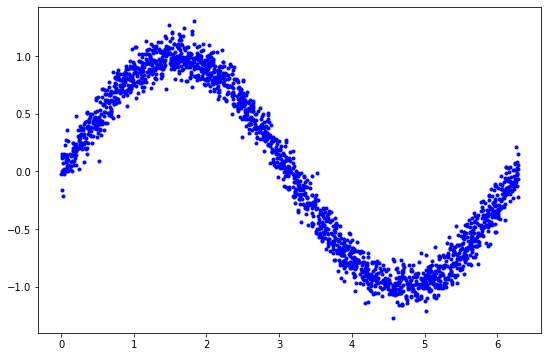

In [276]:

x_values = np.random.uniform(low=0, high=2*math.pi, size=2000)

# Shuffle the values

# Calculate the corresponding sine values
y_values = np.sin(x_values)
# Adding noise
y_values += 0.1 * np.random.randn(*y_values.shape)

# 
plt.figure(figsize=(9,6))
plt.plot(x_values, y_values, 'b.')
plt.show()

In [277]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.3, random_state=24)

In [1]:
# Plot the data in each data set
plt.figure(figsize=(9,6))
plt.plot(X_train, y_train, 'b.', label='Train')
plt.plot(X_test, y_test, 'r.', label='Test')
plt.legend()
plt.show()

NameError: ignored

In [279]:
model = tf.keras.Sequential()
model.add(Dense(30, activation='relu', input_shape=(1, )))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 30)                60        
                                                                 
 dense_88 (Dense)            (None, 20)                620       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_89 (Dense)            (None, 10)                210       
                                                                 
 dense_90 (Dense)            (None, 1)                 11        
                                                                 
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [280]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compiling the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [281]:
# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_split=0.2)

Epoch 1/100
35/35 [==============================] - 1s 7ms/step - loss: 0.5593 - mae: 0.6571 - val_loss: 0.4530 - val_mae: 0.5881
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 0.4560 - mae: 0.5868 - val_loss: 0.3986 - val_mae: 0.5498
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 0.3763 - mae: 0.5325 - val_loss: 0.3034 - val_mae: 0.4786
Epoch 4/100
35/35 [==============================] - 0s 3ms/step - loss: 0.2824 - mae: 0.4559 - val_loss: 0.2149 - val_mae: 0.3992
Epoch 5/100
35/35 [==============================] - 0s 3ms/step - loss: 0.2104 - mae: 0.3905 - val_loss: 0.1405 - val_mae: 0.3230
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 0.1627 - mae: 0.3349 - val_loss: 0.1095 - val_mae: 0.2794
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 0.1375 - mae: 0.3017 - val_loss: 0.1008 - val_mae: 0.2542
Epoch 8/100
35/35 [==============================] - 0s 4ms/step - loss: 0.1284 - m

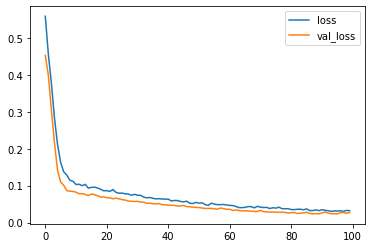

In [282]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.legend()
plt.show()

In [283]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 2ms/step - loss: 0.0245 - mae: 0.1221


[0.024516325443983078, 0.12211337685585022]

In [284]:

# Predictions
predictions = model.predict(X_train)

44/44 [==============================] - 0s 2ms/step


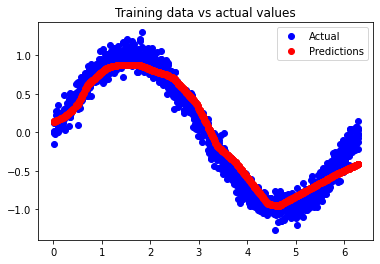

In [285]:
plt.clf()
plt.title("Training data vs actual values")
plt.plot(X_train, y_train, 'bo', label='Actual')
plt.plot(X_train, predictions, 'ro', label='Predictions')
plt.legend()
plt.show()

In [286]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model 
with open("sine_model.tflite", "wb") as f:
  f.write(tflite_model)

#Convert the model to Tensorflow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_generator():
  for value in X_test:
    yield [np.array(value, dtype=np.float32)]

converter.representative_dataset = representative_dataset_generator

# Convert the model
tflite_model = converter.convert()

# Save the optimized model 
with open("sine_model_quantized.tflite",  "wb") as fq:
  fq.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [287]:
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]["index"]
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]

sine_model_predictions = []
sine_model_quantized_predictions = []

for x_value in X_test:
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  sine_model.set_tensor(sine_model_input_index, x_value_tensor)
  sine_model.invoke()

  sine_model_predictions.append(
      sine_model.get_tensor(sine_model_output_index)[0])
  
  sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
  sine_model_quantized.invoke()
  sine_model_quantized_predictions.append(
      sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])